# Py: Customer Sentiment Analysis
**This notebook was originally created by Michael Storozhev for the Data Analytics Applications subject as *Case study 7.2 - Customer sentiment in travel insurance* in the *DAA M07 Natural language processing* module.**

**The Data Analytics Application is a Fellowship Applications (Module 3) subject with the Actuaries Institute that aims to teach students how to apply a range of data analytics skills, such as neural networks, natural language processing, unsupervised learning and optimisation techniques, together with their professional judgement, to solve a variety of complex and challenging business problems. The business problems used as examples in this subject are drawn from a wide range of industries.**

**Find out more about the course [here](https://www.actuaries.asn.au/education-program/fellowship/subjects-and-syllabus/data-analytics-applications-subject).**

### Identify the problem
Businesses often collect feedback from their customers in the form of free-text reviews. This results in businesses receiving very rich but unstructured information about areas where they are meeting their customers’ needs and areas where customers are unsatisfied.

It can be difficult to draw conclusions from this large volume of unstructured data without the help of NLP. The task in this case study is to analyse customer reviews in travel insurance to identify key areas of dissatisfaction. The aim for the business would then be to investigate these areas of discontent so they can improve their future customer service offering.


### Purpose:
This notebook walks through the use of NLP to analyse customer sentiment to better understand travel insurance related complaints. The objective of the case study is to identify key areas of customer satisfaction (or dissatisfaction) with travel insurance products.

### References:
The dataset that is used in this case study was sourced from the Product Review website (https://www.productreview.com.au). ProductReview.com.au is a website devoted to providing consumer opinions on products, services and businesses in Australia.

The dataset for this case study includes 19,395 product reviews in the period May 2017 to August 2020 that relate to travel insurance from 12 different providers.

## Packages
This section installs packages that will be required for this exercise/case study.
n.b. for installing ``wordcloud``, if ``pip install wordcloud`` gives an error, try ``conda install -c conda-forge wordcloud``.

In [1]:
# Packages for data management.
import pandas as pd
import numpy as np

# Packages to be used in pre-processing the text.
import re
import nltk
nltk.download('stopwords') # For a standard list of stopwords.
nltk.download('wordnet') # For lemmatisation.
import pkg_resources
!pip install symspellpy
from symspellpy import SymSpell, Verbosity

# Packages for visualisation.
# from pprint import pprint
# import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# For vectorisation using TF-IDF and t-SNE.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

# For clustering sentences using K-Means clustering.
from sklearn.cluster import KMeans

# For vectorisation using BERT.
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

# For evaluating the clustering model.
from sklearn.metrics import silhouette_score

[nltk_data] Downloading package stopwords to /Users/Jacky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Jacky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Functions

This section defines functions that will be used for this exercise/case study.

In [2]:
# Define a function to clean text.
# Note that not all of these cleaning steps may be needed for different models.
def clean_text(text, full_clean=1):
    ''' Basic cleaning does the following:
        - converts all words to lowercase;
        - removes punctuation and special characters;
        - uses 'split' to create tokens; and
        - fixes spelling mistakes.

        Full cleaning also does the following:
        - removes stop words;
        - performs stemming; and
        - performs lemmatisation.
    '''
    
    # Convert all text to lower case.
    text = text.lower()
    
    # Remove all non-digits/non-alphabetical characters ('\w')
    # or  white spaces ('\s').
    text = re.sub(r'[^\w\s]', '', str(text).strip())

    # Create tokens from the text.
    text_list = text.split()

    # Fix spelling mistakes.
    # The sym_spell.lookup function highlights words that are not in the
    # symspell dictionary and offers suggested alternatives for these words.
    text_list_spell = []
    for word in text_list:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
        if suggestions:
            text_list_spell.append(suggestions[0].term)
        else:
            pass
    text_list = text_list_spell[:]
    
    if full_clean==1:
        # Remove stopwords.
        text_list = [word for word in text_list if word not in stopwords]

        # Perform stemming.
        ps = nltk.stem.porter.PorterStemmer()
        text_list = [ps.stem(word) for word in text_list]

        # Perform lemmatisation.
        wnl = nltk.stem.wordnet.WordNetLemmatizer()
        text_list = [wnl.lemmatize(word) for word in text_list]
        
    result = ' '.join(text_list)
    return result

In [3]:
# Define a function to create a word cloud from the words in the dataset.
def get_wordcloud(topic,model,blacklist=[]):

    print('Getting wordcloud for topic {} ...'.format(topic+1))
    body_list = list(dataset['body'][dataset[model] == topic])
    
    for each in blacklist:
        body_list = [w.replace(each, '') for w in body_list]
    tokens = ' '.join(body_list)
    wordcloud = WordCloud(width=800, height=560,
                          background_color='white', collocations=False,
                          min_font_size=10).generate(tokens)

    # plot the WordCloud image
    plt.figure(figsize=(8, 5.6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=5)

## Data
This section:
- imports the data that will be used in the modelling;
- explores the data; and
- prepares the data for modelling.

### Import data

In [4]:
# Create dataset from the csv import.
dataset = pd.read_csv(
    'https://actuariesinstitute.github.io/cookbook/_static/daa_datasets/DAA_M07_CS2_data.csv.zip', 
    encoding='cp1252')
print(dataset.shape)

(19395, 6)


In [5]:
# Get spelling datasets.
sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename('symspellpy', 'frequency_dictionary_en_82_765.txt')
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Add some common words to the dictionary that are likely to be found in the
# case study corpus, to avoid them being incorrectly 'fixed' by the spell checker.
sym_spell.create_dictionary_entry('covid', 5)
sym_spell.create_dictionary_entry('coronavirus', 5)

True

### Explore data (EDA)

In [6]:
# View the features of the dataset.
print(dataset.columns)

Index(['pubDate', 'rating', 'title', 'body', 'url', 'pubMonth'], dtype='object')


In [7]:
# Check the size of the dataset.
print(dataset.shape)

(19395, 6)


In [8]:
# Print the text of the first review.
dataset['body'][0]

'I used this travel insurance mainly for the car hire excess. I paid $108 for cover for a family of 5, compared to the car company  excess only insurance of $200. Booking online very easy, with immediate confirmations. I did not claim, but felt assured from other people who had needed to, giving generally positive reviews. Will definitely use this company again for future travels, and would recommend to others.\n\n'

### Prepare data

This section involves cleaning the data to prepare it for analysis. The following cleaning steps are taken:
- convert all words to lowercase;
- remove punctuation and special characters;
- use 'split' to create tokens;
- fix spelling mistakes;
- remove stop words (when doing a full clean);
- perform stemming (when doing a full clean); and
- perform lemmatisation (when doing a full clean).

#### Clean data

In [9]:
# Get stopwords.
stopwords = nltk.corpus.stopwords.words('english')

In [10]:
# Check that the cleaning function defined at the top of the notebook
# is working as expected.
review_number = 11
print('--Original')
print(dataset['body'][review_number-1])
print('\n')
print('--Basic clean')
print(clean_text(dataset['body'][review_number-1], full_clean=0))
print('\n')
print('--Full clean')
print(clean_text(dataset['body'][review_number-1], full_clean=1))

--Original
please please please do not get insurance with this company unless you have the time to write down eveyhing you had pre-exsisting even gastro 5 years ago because i can promise you if you didn't have it before you will by the time they finish with you so now i will take the time (my precise time) to write a review once a week and hopefully save some poor soul the stress and confusion that i have had to deal with good luck
none zero zilch
i should have read reviews first but because travel agent recommended i thought they would have been really good. foolish me to trust people no wonder the world is becoming what it is with nobody caring well kharma is a real thing so be careful who you rip off and staff be realistic do you think the company will care when you walk out the  door fool fool fool


--Basic clean
please please please do not get insurance with this company unless you have the time to write down everything you had preexisting even castro a years ago because i can pr

In the above example, take note of what the cleaning process did to the following words:
- 'eveyhing' was corrected to 'everything' by the spell-checker;
- 'pre-exsisting' was corrected to 'preexisting' by the spell-checker;
- 'gastro' was corrected to 'castro' by the spell-checker; and
- 'please' was converted to 'plea' by the stemmer and/or the lemmatiser.

Do all of these changes make sense?

You should look at the cleaning output for a few different reviews to find other examples of changes that have been made by the cleaning function. Are you happy with all of these changes?

In [11]:
# Run the cleaning function on the full dataset. This step can take a while to run.
dataset['body_clean_full'] = dataset['body'].apply(lambda x: clean_text(x, full_clean=1))
    # The lambda function is used above to apply the clean_text function to all the
    # reviews in the corpus.
dataset['body_clean_bert'] = dataset['body'].apply(lambda x: clean_text(x, full_clean=0))
    # The 'body_clean_bert' uses a basic clean to prepare the data for use with the
    # Bert model.
dataset.head()

,pubDate,rating,title,body,url,pubMonth,body_clean_full,body_clean_bert
0,2016-07-20T00:30:41Z,5,Excellent value.,I used this travel insurance mainly for the ca...,https://www.productreview.com.au/reviews/30937...,2016-07,use travel insur mainli car hire excess paid c...,i used this travel insurance mainly for the ca...
1,2017-10-30T09:40:07Z,5,Great service,We took out a cover more policy for a quick 10...,https://www.productreview.com.au/reviews/ba5e7...,2017-10,took cover polici quick day trip famili four m...,we took out a cover more policy for a quick of...
2,2017-01-08T03:47:52Z,1,Stay Away from CBA Allianz Travel Insurance,My wife developed a medical condition so we ha...,https://www.productreview.com.au/reviews/314fd...,2017-01,wife develop medic condit put trip month put c...,my wife developed a medical condition so we ha...
3,2016-09-15T05:16:52Z,5,Peace of mind should any problems arise,Prices getting more expensive as we get older ...,https://www.productreview.com.au/reviews/0fa5b...,2016-09,price get expens get older even good health st...,prices getting more expensive as we get older ...
4,2018-10-05T07:10:15Z,4,made a claim,needed to make a claim when I had to cut short...,https://www.productreview.com.au/reviews/a0508...,2018-10,need make claim cut short trip father die sudd...,needed to make a claim when i had to cut short...


#### Subset data
This section allows you to subset the data to be used in the analysis. For example, you might choose a subset of the entire date range, or you might choose to review only observations with a certain rating.

In [12]:
# Set date range of reviews to be analysed.

Months = ['2019-01','2019-02','2019-03','2019-04','2019-05','2019-06',
          '2019-07','2019-08','2019-09','2019-10','2019-11','2019-12',
          '2020-01','2020-02','2020-03','2020-04','2020-05','2020-06']
          # Because 'pubMonth' is recorded as a string, a list of 
          # string values is created, representing the months of
          # interest for this analysis.
          # An alternative approach would be to convert the 'pubDate' into
          # a date and search within a specified date range.

# Choose which reviews, based on rating, will be included in the analysis.
# In this case, the focus will be on reviews with a low rating of 1 or 2,
# to try to understand what makes customers complain about travel insurance.

ratings = [1,2]

# If you want to apply the subsetting specified above, then remove the '#'
# at the start of each line below:

# dataset = dataset[dataset['pubMonth'].isin(Months)]
# dataset = dataset[dataset['rating'].isin(ratings)]
# print(dataset.shape)

#### Vectorise
Two vectorisation approaches are used below:
- approach 1 uses TF-IDF; and
- approach 2 uses BERT.

##### TF-IDF

In this approach, TF-IDF is used to get the statistical weights of the tokens in each review. These weights are then reduced to two dimensions using t-SNE (t-SNE is an alternative dimension reduction technique to PCA). This makes it easier to visualise the different clusters that are found using K-Means clustering (see the Modelling section of the notebook).

In [13]:
# Generate TF-IDF weights
clean_input = dataset['body_clean_full'].tolist()
tfidf = TfidfVectorizer()
embedding_tfidf = tfidf.fit_transform(clean_input)
print('Shape of list containing reviews and their tf-idf weights:', embedding_tfidf.shape)

tsne1 = TSNE(n_components=2)
embedding_tfidf_tsne = tsne1.fit_transform(embedding_tfidf)
print('Shape of list containing reviews and their t-SNE components:', embedding_tfidf_tsne.shape)

Shape of list containing reviews and their tf-idf weights: (19395, 8598)
Shape of list containing reviews and their t-SNE components: (19395, 2)


##### BERT

This approach uses BERT to get the encodings for each review. These weights are then again reduced to two dimensions using t-SNE to make it easier to visualise the different clusters that are found using K-Means clustering.

In [14]:
# Import the BERT data set (the text that has only had basic cleaning).
bert_input = dataset['body_clean_bert'].tolist()
print('Getting vector embeddings for BERT ...')

# Create a model to perform embeddings using BERT.
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
# Perform the embeddings.
# Note that the first time this is run, the BERT model will download.
# This can take some time as the model is approximately 265Mb.
embeddings = model.encode(bert_input, show_progress_bar=True)
embedding_BERT = np.array(embeddings)

print('Getting vector embeddings for BERT. Done!')

print('Shape of list containing reviews and their BERT weights:', embeddings.shape)

# Again, t-SNE is applied to reduce the dimension of the BERT embeddings.
tsne2 = TSNE(n_components=2)
embedding_BERT_tsne = tsne2.fit_transform(embedding_BERT)
print('Shape of list containing reviews and their t-SNE components:',
      embedding_BERT_tsne.shape)

Getting vector embeddings for BERT ...



Getting vector embeddings for BERT. Done!
Shape of list containing reviews and their BERT weights: (19395, 768)
Shape of list containing reviews and their t-SNE components: (19395, 2)


In [15]:
# Print an example of a BERT embedding.
print('Bert embedding sample', embeddings[0][0:50])
  # This prints the first 50 vectors created by the BERT
  # embedding for the first review in the dataset.

Bert embedding sample [ 0.07839592 -0.03426155  0.34549624 -0.5389152   0.09483199 -0.6143829
  0.45555508 -0.80263364  0.26621756 -0.18330695  0.24159609  1.0325977
  0.10215842  0.22790357 -0.14811812 -1.2008395   1.0383072   0.52433145
 -0.8693367  -0.33057952 -0.5125885   0.510791    0.14292425  1.0891778
 -0.37536004 -0.6041657   0.05691441 -0.4669992   0.818177    0.42899376
 -0.21324089 -0.14957345 -1.0235013  -0.21922049  0.15937041 -0.31900945
  0.9084414  -0.0330176  -0.08699284 -0.9079751  -0.14651097 -0.49356133
  0.3114979   1.7692568  -0.07382092 -0.18199839 -0.18566728  0.35210767
  0.03142061  0.11990058]


## Modelling
This section uses the vectorised reviews to perform topic modelling. This allows the reviews to be clustered into different topics, to identify the main themes that emerge from the reviews.

#### Using TF-IDF vectorisation

In [16]:
# Use the TF-IDF approach to cluster the reviews into K topics.
K = 6
kmeans_model1 = KMeans(K)
score_tfidf_tsne = kmeans_model1.fit(embedding_tfidf_tsne).score(embedding_tfidf_tsne)
    # This step fits the kmeans model and calculates a cluster score (WCSS)
    # for the model. WCSS measures the (negative) sum of squared distances
    # of observations to their closest cluster centroid, so a smaller score
    # indicates a better clustering of the data.
labels_tfidf_kmeans = kmeans_model1.predict(embedding_tfidf_tsne)
dataset['label_TFIDF_KMeans'] = list(labels_tfidf_kmeans)
print(score_tfidf_tsne)

-5229479.5


Getting wordcloud for topic 1 ...
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 4 ...
Getting wordcloud for topic 5 ...
Getting wordcloud for topic 6 ...


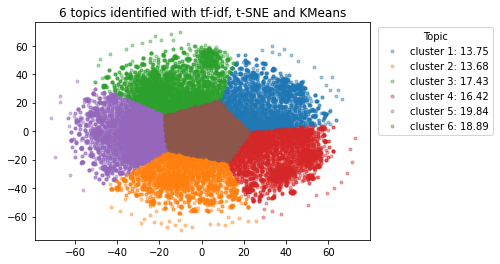

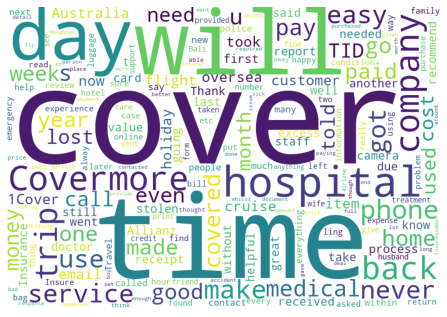

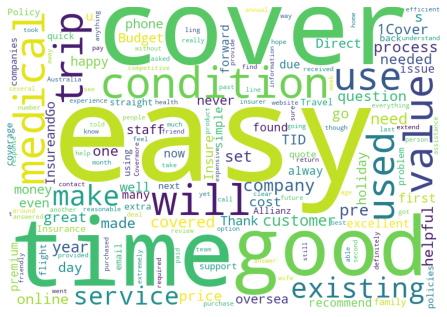

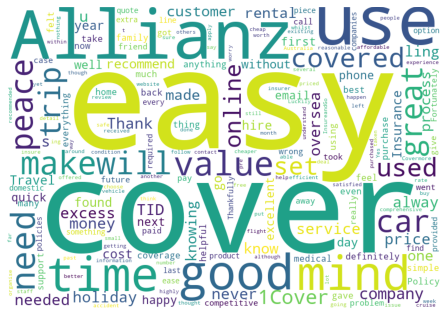

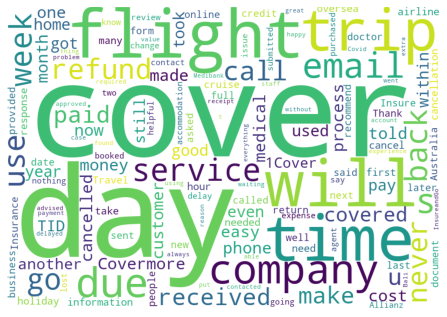

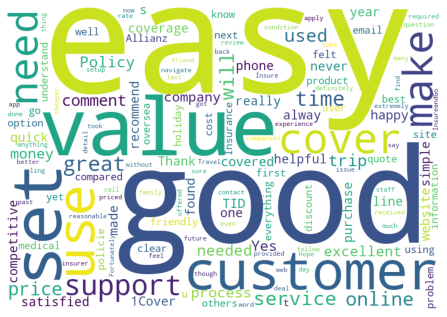

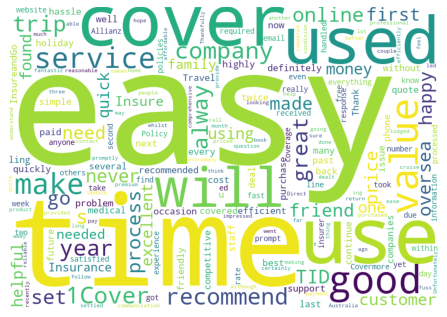

In [17]:
# Create a set of distinct labels from the clustering.
labels1 = np.array(labels_tfidf_kmeans)
distinct_labels1 =  set(labels_tfidf_kmeans)

# Create a plot of the reviews clustered by 'topic'.
# Note that at this point the 'topic' of each cluster has not yet
# been analysed or defined.
n = len(labels_tfidf_kmeans)
counter = Counter(labels1)
for i in range(len(distinct_labels1)):
    ratio = (counter[i] / n )* 100
    cluster_label = f'cluster {i+1}: { round(ratio,2)}'
    x = embedding_tfidf_tsne[:, 0][labels1 == i]
    y = embedding_tfidf_tsne[:, 1][labels1 == i]
    plt.plot(x, y, '.', alpha=0.4, label= cluster_label)
plt.legend(title='Topic',loc = 'upper left', bbox_to_anchor=(1.01,1))
plt.title('{} topics identified with tf-idf, t-SNE and KMeans'.format(K))

# Create a list of context specific common words that will
# be hidden in the word clouds produced.
hidden_words = ['insurance','travel','policy','claim']

# Create a word cloud to help identify the meaning of
# each 'topic' identified in the KMeans clustering.
for each in range(0,K):
    get_wordcloud(each,'label_TFIDF_KMeans',hidden_words)


### Using BERT vectorisation

In [18]:
# Apply K-Means clustering to the BERT vectors.
K2 = 6
kmeans_model2 = KMeans(K2)
score_BERT_tsne = kmeans_model2.fit(embedding_BERT_tsne).score(embedding_BERT_tsne)
labels_BERT_kmeans = kmeans_model2.predict(embedding_BERT_tsne)
dataset['label_BERT_KMeans'] = list(labels_BERT_kmeans)
print(score_BERT_tsne)

-4882896.0


Getting wordcloud for topic 1 ...
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 4 ...
Getting wordcloud for topic 5 ...
Getting wordcloud for topic 6 ...


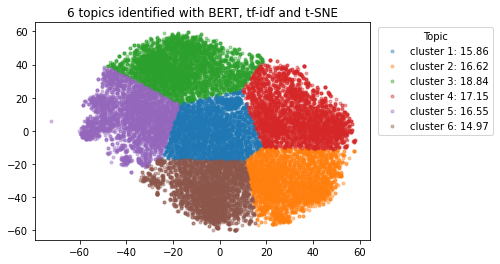

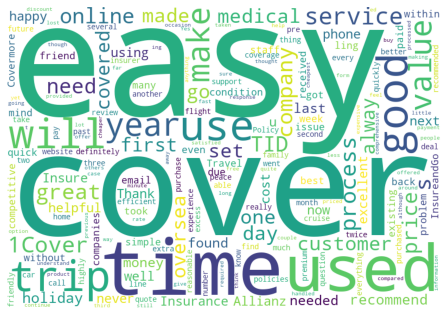

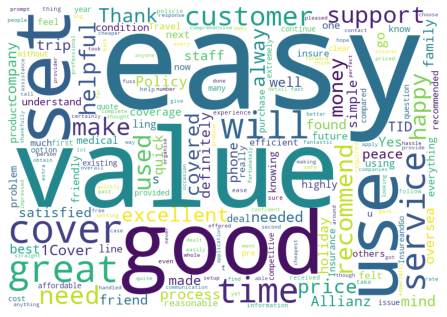

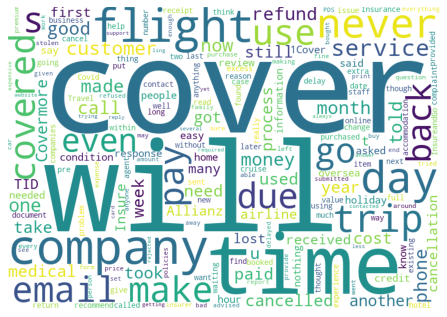

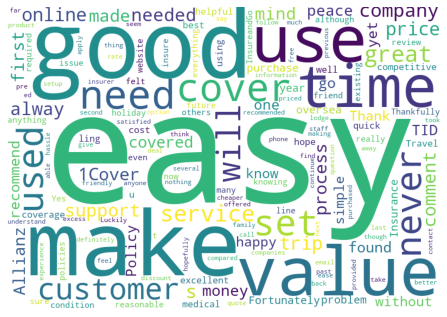

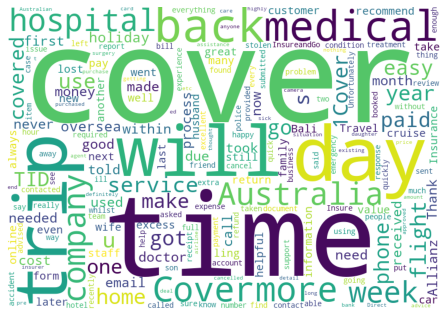

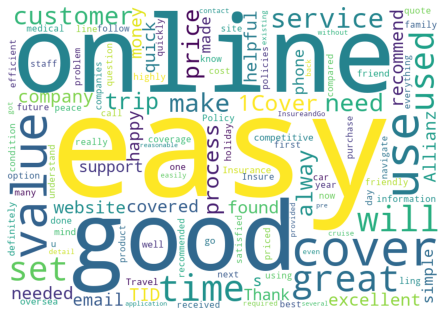

In [19]:
# Create a set of distinct labels from the clustering.
labels2 = np.array(labels_BERT_kmeans)
distinct_labels2 =  set(labels_BERT_kmeans)

# Create a plot of the reviews clustered by 'topic'
# where the 'topic' of each cluster has not yet
# been analysed.
n = len(embedding_BERT_tsne)
counter = Counter(labels2)
for i in range(len(distinct_labels2)):
    ratio = (counter[i] / n )* 100
    cluster_label = f'cluster {i+1}: { round(ratio,2)}'
    x = embedding_BERT_tsne[:, 0][labels2 == i]
    y = embedding_BERT_tsne[:, 1][labels2 == i]
    plt.plot(x, y, '.', alpha=0.4, label= cluster_label)
plt.legend(title='Topic',loc = 'upper left', bbox_to_anchor=(1.01,1))
plt.title('{} topics identified with BERT, tf-idf and t-SNE'.format(K2))

# Create a list of context specific common words that will
# be hidden in the word clouds producted.
hidden_words2 = ['insurance','travel','policy','claim']

# Create a word cloud to help identify the meaning of
# each 'topic' identified in the KMeans clustering.
for each in range(0,K2):
    get_wordcloud(each,'label_BERT_KMeans',hidden_words2)

## Evaluate
This section performs some evaluation of the topic modelling using TF-IDF and BERT.

The metric used below is the 'silhouette value' which is a measure of how similar observations are to their own cluster compared to other clusters. This is an alternative evaluation measure to those presented in Module 7.

The best silhouette value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that an observation has been assigned to the wrong cluster, as a different cluster is more similar.

In [20]:
# Calculate the silhouette value for the TF-IDF based clustering after t-SNE
# has been applied to reduce the dimension of the embeddings.
print('Silhouette Score (TF-IDF and t-SNE):',
      silhouette_score(embedding_tfidf_tsne , labels_tfidf_kmeans))

# Calculate silhouette values for the BERT based clustering.
#print('Silhouette Score (BERT):',
#      silhouette_score(embedding_BERT , labels_BERT_kmeans))

# Calculate the silhouette value for the BERT based clustering after t-SNE
# has been applied to reduce the dimension of the embeddings.
print('Silhouette Score (BERT and t-SNE):', 
      silhouette_score(embedding_BERT_tsne , labels_BERT_kmeans))

# The WCSS scores for the TF-IDF and BERT models are also shown:
print('WCSS Score (TF-IDF and t-SNE):', score_tfidf_tsne)
print('WCSS Score (BERT):', score_BERT_tsne)

Silhouette Score (TF-IDF and t-SNE): 0.3606951
Silhouette Score (BERT and t-SNE): 0.3837916
WCSS Score (TF-IDF and t-SNE): -5229479.5
WCSS Score (BERT): -4882896.0


The output above suggests that the embeddings using BERT produced marginally better clustering outcomes, with a slightly higher silhouette value and WCSS score.

# Commentary
The 'Monitor results' section of Case Study 2 in Module 6 of the DAA course contained a discussion of how the analysis such as that conducted above can be used to interpret key areas or themes of feedback from travel insurance customers.

The reader can play around with analysing different subsets of the reviews in this case study, to see what themes emerge for reviews with high and low ratings, and for reviews over different time periods.